# Natural Language Processing Tutorial 3 - Introduction to Transformers with Huggingface 

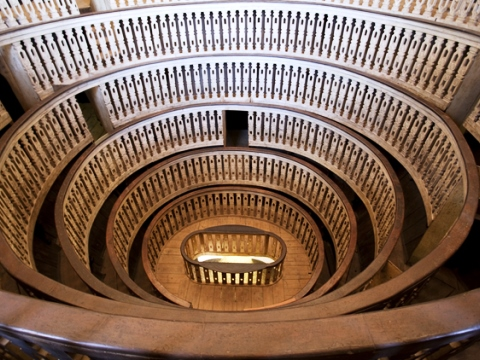




*   What you will learn today
  * Huggingface Hub: the ecosystem of Huggingface
  * Huggingface 4 main libraries:
      * [transformers](https://huggingface.co/docs/transformers)
      * [tokenizers](https://huggingface.co/docs/tokenizers) 
      * [datasets](https://huggingface.co/docs/datasets)
      * [evaluate](https://huggingface.co/docs/evaluate)





## Huggingface Hub

*   The first thing to learn is the structure of Huggingface Hub
*   Huggingface Hub is a place where you can find plenty of [models](https://huggingface.co/models) and [datasets](https://huggingface.co/datasets)
* BERT is the most downloaded model and is available [here](https://huggingface.co/bert-base-uncased)



## Models and tokenizers

First we need to install the libraries

In [36]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### The "Auto" Classes of Hugginface

*  The first thing that we need to do is to download a pretrained model and its tokenizer
* We need to use the classes
  * ```AutoModel```
  *  ```AutoTokenizer``` 
* We can load both using the ```from_pretrained``` function
* The opposite function is the ```save_pretrained``` function, which can be used to save a model to disk




In [1]:
from transformers import AutoTokenizer, AutoModel
 
model_name = "bert-base-uncased"

model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

C:\Users\Tommaso\anaconda3\envs\pd_nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly 

### Encoder-only models

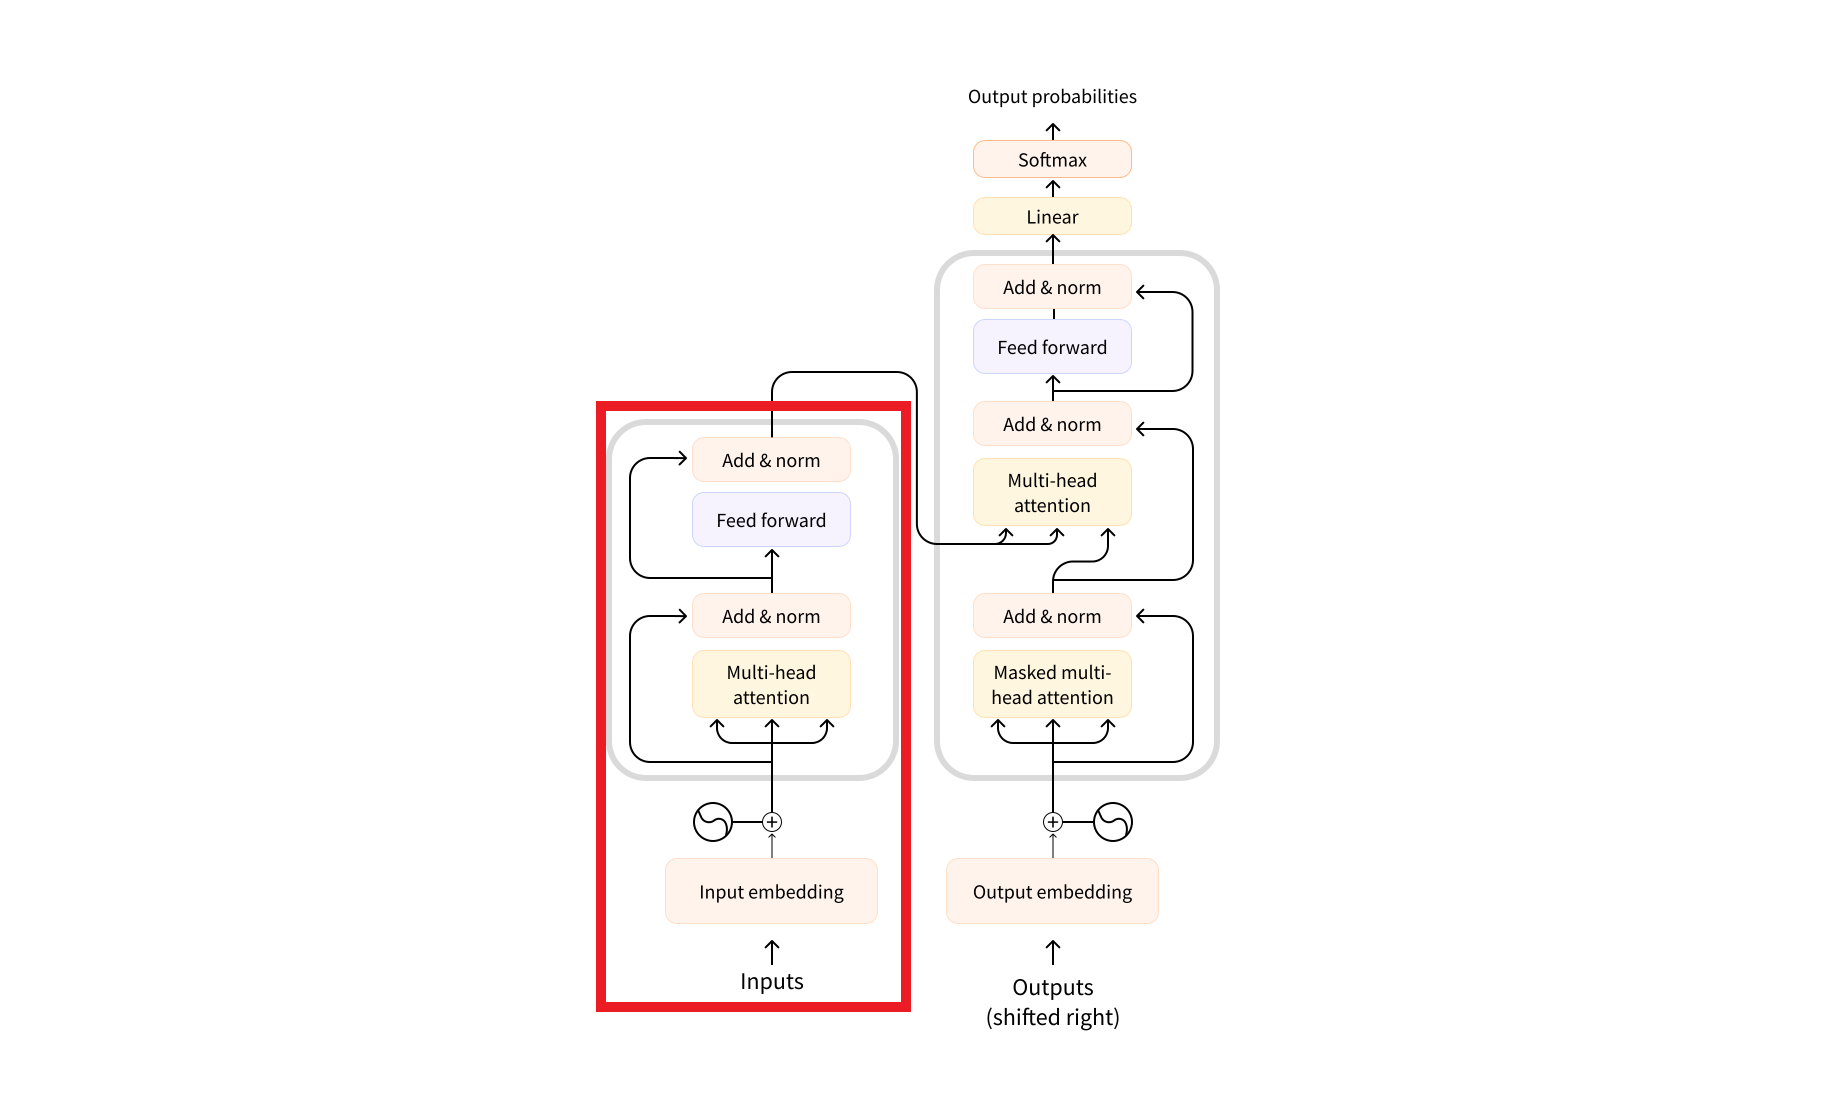

### Tokenizers outputs

*  Let's focus on the tokenizer for now
*  The tokenizer applies the following steps:
  1. Preprocesses the text and tokenizes it in subwords
  2. Associates to every subword an ```input_id``` which is used to fetch its embedding in the embedding layer (or layer 0)
  3. Adds ```attention_mask``` and ```token_type_ids```



In [38]:
tokenizer("I love tokenization")

{'input_ids': [101, 1045, 2293, 19204, 3989, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### The ```input_ids``` 

*   After tokenizing into subwords, each subword is associated to a ```input_id``` which tells the model which embedding to get for that subword
* You can think of it as a row index in the embedding matrix
    * love ➡️ 2293 ➡️ get embedding in row 2293



In [3]:
tokenizer.tokenize("I love tokenization", add_special_tokens=True)

['[CLS]', 'i', 'love', 'token', '##ization', '[SEP]']

In [4]:
tokenizer("I love tokenization")

{'input_ids': [101, 1045, 2293, 19204, 3989, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [39]:
output = tokenizer("I love tokenization")
tokenizer.convert_ids_to_tokens(output["input_ids"])

['[CLS]', 'i', 'love', 'token', '##ization', '[SEP]']

In [41]:
output = tokenizer("I love tokenization")
tokenizer.decode(output["input_ids"])

'[CLS] i love tokenization [SEP]'

### The ```attention_mask``` 

*   Suppose that we have 2 sentences of different lengths
*   If the sentences are in the same batch, the shortest one needs to be padded: we need to append [PAD] tokens to the shortest sentence so that they have the same length
* However, we don't want the self-attention to operate over the [PAD] tokens
* tokenizers handles all of this for us



In [42]:
sentences = ["I love tokenization", "I really like the city of Padua"]
output = tokenizer(sentences, padding=True, return_tensors='pt')

In [43]:
print(output["input_ids"])
print(output["attention_mask"])

tensor([[  101,  1045,  2293, 19204,  3989,   102,     0,     0,     0],
        [  101,  1045,  2428,  2066,  1996,  2103,  1997, 24941,   102]])
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [44]:
print(tokenizer.convert_ids_to_tokens(output["input_ids"][0]))
print(tokenizer.convert_ids_to_tokens(output["input_ids"][1]))

['[CLS]', 'i', 'love', 'token', '##ization', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'i', 'really', 'like', 'the', 'city', 'of', 'padua', '[SEP]']


### The ```token_type_ids``` 

*  Recall that the input embeddings to a transformers are the result of a sum of three elements:
  * Token embeddings: the embeddings that are extracted from the embedding matrix using ```input_ids```
  * Positional embeddings: this are sinusoidal or learned and give the transformer the position information
  * Segment embeddings: when we are doing sentence-pair tasks, i.e. the input consists of $ [CLS] \; seq_A \; [SEP] \; seq_B \; [SEP]$, we may want to add to each embedding the information on the originating sentence 
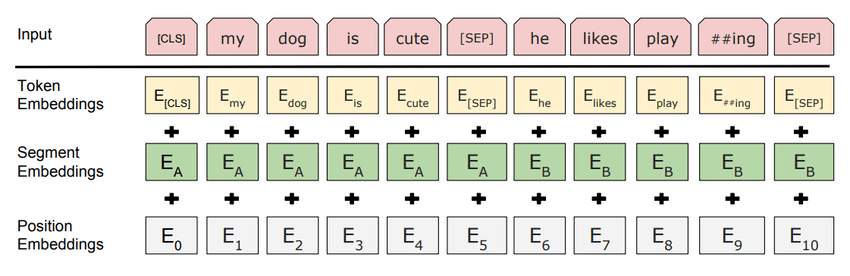



In [45]:
output = tokenizer("The sun is shining today", "Today it's rainy") # sentence-pair tokenization
output

{'input_ids': [101, 1996, 3103, 2003, 9716, 2651, 102, 2651, 2009, 1005, 1055, 16373, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [46]:
tokenizer.decode(output["input_ids"])

"[CLS] the sun is shining today [SEP] today it's rainy [SEP]"

In [47]:
# Notice the difference
 
output_single_sent = tokenizer(["The sun is shining today", "Today it's rainy"]) # single-sentence tasks
output_sent_pair = tokenizer("The sun is shining today", "Today it's rainy") # sentence-pair tasks

print(tokenizer.batch_decode(output_single_sent["input_ids"]))
print(tokenizer.decode(output_sent_pair["input_ids"]))

['[CLS] the sun is shining today [SEP]', "[CLS] today it's rainy [SEP]"]
[CLS] the sun is shining today [SEP] today it's rainy [SEP]


### The transformer model in Huggingface

In [48]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [49]:
model.encoder.layer[5]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

### Feeding a batch to a transformer

In [50]:
sequences = ["Using transformers is quite simple", "Natural Language Processing is the coolest area of AI", "BERT is an encoder-only model"]
batch = tokenizer(sequences, padding=True, return_tensors='pt')
print(batch["input_ids"], batch["attention_mask"], batch["token_type_ids"], sep="\n\n", end="\n\n")
print(tokenizer.batch_decode(batch["input_ids"]))

tensor([[  101,  2478, 19081,  2003,  3243,  3722,   102,     0,     0,     0,
             0,     0],
        [  101,  3019,  2653,  6364,  2003,  1996,  4658,  4355,  2181,  1997,
          9932,   102],
        [  101, 14324,  2003,  2019,  4372, 16044,  2099,  1011,  2069,  2944,
           102,     0]])

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

['[CLS] using transformers is quite simple [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] natural language processing is the coolest area of ai [SEP]', '[CLS] bert is an encoder - only model [SEP] [PAD]']


In [51]:
model_output = model(**batch) # equivalent to model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'])
print(model_output.last_hidden_state) 
print("batch_size x seq_len x hidden_dim", model_output.last_hidden_state.shape, sep="\n")

tensor([[[-2.0453e-01,  7.0865e-02,  1.5989e-01,  ..., -5.2576e-01,
          -8.6742e-02,  6.8585e-01],
         [ 2.4598e-01,  4.5985e-01, -1.4832e-01,  ..., -2.9959e-01,
          -6.3807e-02,  2.2089e-01],
         [ 1.6290e+00, -7.5314e-02, -1.6926e-01,  ..., -5.9800e-01,
          -2.4732e-01,  5.8838e-01],
         ...,
         [ 1.8744e-01, -1.4395e-01,  1.3122e-01,  ...,  5.4823e-02,
          -3.0255e-01,  4.1559e-01],
         [-4.2708e-01, -4.2683e-01,  1.7270e-01,  ...,  2.9482e-01,
           5.4690e-02,  4.9447e-01],
         [-9.1995e-02, -2.2785e-01,  9.8050e-02,  ...,  1.3341e-01,
          -1.4247e-01,  4.9720e-01]],

        [[-4.2831e-02,  2.8874e-02,  6.4191e-02,  ..., -1.5476e-01,
          -1.0478e-02,  5.8216e-01],
         [-1.0164e-01,  1.8912e-01, -5.2067e-01,  ..., -7.8897e-02,
           1.9872e-01,  2.9997e-01],
         [-5.4308e-01,  2.5865e-01,  5.8880e-01,  ..., -5.6930e-01,
          -3.8819e-01, -1.1054e-01],
         ...,
         [-3.7056e-01,  4

In [52]:
model_output = model(**batch, output_hidden_states=True) # equivalent to model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'])
all_states = model_output.hidden_states # list of outputs from all transformer layers, layer 0, 1, 2, ...., 12 (layer 0 is the embedding layer)
print(len(all_states))
print(all_states[3]) # output of 4th layer

13
tensor([[[ 0.0215, -0.2639, -0.0377,  ...,  0.1970,  0.1228,  0.1301],
         [-0.7210,  0.7983, -0.1146,  ...,  0.5685,  0.2871,  0.3625],
         [ 1.8263,  0.6771, -1.2945,  ...,  0.0750,  0.1787,  0.8844],
         ...,
         [-0.0844, -0.4028,  0.3619,  ...,  0.8078, -0.0434, -0.0026],
         [-0.5844, -0.3105,  0.3228,  ...,  0.9155,  0.0648,  0.0206],
         [-0.4847, -0.2071,  0.3676,  ...,  0.7910,  0.0471, -0.0331]],

        [[ 0.1411, -0.2476, -0.1009,  ...,  0.1248,  0.1271,  0.1129],
         [ 0.1099,  0.1498, -0.2346,  ...,  0.0810,  0.2272, -0.7285],
         [ 0.4657,  0.3590, -0.0722,  ..., -0.0788, -0.0577, -0.1413],
         ...,
         [-0.5130,  0.1590,  0.2484,  ...,  0.1736, -0.5944,  0.0723],
         [-0.6027,  0.2167,  0.2660,  ...,  0.7422, -0.0018, -0.8578],
         [-0.0624, -0.1068,  0.1162,  ...,  0.0308,  0.0711, -0.0221]],

        [[ 0.0538, -0.4406, -0.1444,  ...,  0.3530,  0.2185,  0.1304],
         [ 1.1208,  0.3139,  0.7051,  ...,

## Datasets

### Loading a dataset from the Huggingface Hub

- We are using the MRPC (Microsoft Research Paraphrasing Corpus) dataset that is part of the General Language Understanding Evaluation (GLUE) benchmark
- Task: given two sentences, assign positive class (1) if the two sentences are paraphrases of one another (assign 0 otherwise)
- [Link](https://huggingface.co/datasets/glue) to the dataset on the hub

In [53]:
from datasets import load_dataset
mrpc_dataset = load_dataset("glue", "mrpc")
mrpc_dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

Let's check the dataset features and examples

In [54]:
print(mrpc_dataset["train"].features)

{'sentence1': Value(dtype='string', id=None), 'sentence2': Value(dtype='string', id=None), 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None), 'idx': Value(dtype='int32', id=None)}


In [55]:
print(mrpc_dataset["train"][0], end="\n\n")
print(mrpc_dataset["train"][1])

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .', 'label': 1, 'idx': 0}

{'sentence1': "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .", 'sentence2': "Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .", 'label': 0, 'idx': 1}


### Operations on datasets

The datasets library supports various operations on datasets such as slicing and column selection

In [56]:
mrpc_dataset["train"][:10] # Slicing

{'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
  'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .',
  'Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .',
  'The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .',
  'The DVD-CCA then appealed to the state Supreme Court .',
  'That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .',
  'Shares of Genentech , a much larger company with several products on the market , ros

In [57]:
mrpc_dataset["train"]["label"] # Column selection 

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,


```select``` returns rows according to a list of indices:

In [58]:
sel_data = mrpc_dataset["train"].select([0, 11, 22, 1514])

```filter``` returns rows that match a specified condition:


In [59]:
filtered_data = mrpc_dataset["train"].filter(lambda example: example["sentence1"].startswith("This"))
filtered_data[:-1]

{'sentence1': ['This Palm OS smart phone is the last product the company will release before it becomes a part of palmOne .',
  "This week 's tour will take Bush to Senegal , South Africa , Botswana , Uganda and Nigeria , and is aimed at softening his warrior image at home and abroad .",
  'This was around the time Congress was debating a resolution granting the President broad authority to wage war .',
  "This morning , at UM 's New York office , Coen revised his expectations downward , saying that spending would instead rise 4.6 percent to $ 247 billion .",
  'This is the only planet that has been found in orbit around a binary star system .',
  'This year , local health departments hired part-time water samplers and purchased testing equipment with a $ 282,355 grant from the Environmental Protection Agency .',
  'This was double the $ 818 million reported for the first three months of 2001 .',
  'This change in attitude gave upscale purveyors including Neiman Marcus , the parent of 

Train and test splitting

In [60]:
mrpc_dataset["train"].train_test_split(test_size=0.1)

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3301
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 367
    })
})

The map function is one of the most important functions: it applies a function to every example in the dataset. It's primary usage in NLP is for tokenization

In [61]:
new_dataset = mrpc_dataset["train"].map(lambda example: {"new_sentence1": "Sentence 1: " + example["sentence1"]}) # Create a new column as a function of the previous one
new_dataset[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0,
 'new_sentence1': 'Sentence 1: Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .'}

### Saving and loading datasets from disk

We also can save datasets to disk and reload them at our convience

In [62]:
from datasets import load_from_disk
save_path = "datasets/my_data"

new_dataset.save_to_disk(save_path) # Saving
reloaded_dataset = load_from_disk(save_path) # Loading

Saving the dataset (0/1 shards):   0%|          | 0/3668 [00:00<?, ? examples/s]

### Other functions

Other useful functions:

- [Rename, remove, cast, and flatten](https://huggingface.co/docs/datasets/v2.12.0/en/process#rename-remove-cast-and-flatten)
- [Concatenate, interleave](https://huggingface.co/docs/datasets/v2.12.0/en/process#concatenate)

Datasets can also be exported to:
  - csv
  - json
  - parquet
  - sql
  - In-memory objects Pandas Dataframe / Python Dictionary
 
See [Guide to export](https://huggingface.co/docs/datasets/v2.12.0/en/process#export)

## Fine-tuning a transformer model

Fine-tuning transformer models:

  - We want to fine-tune BERT on the MRPC (Microsoft Research Paraphrase Corpus) dataset
  - The first thing to do is to preprocess the data using tokenizer:
    - The task is a **sentence-pair classification task**
    - We need every input to be in the format 
$ [CLS] \; seq_1 \; [SEP] \; seq_2 \; [SEP]$

    - We will feed the embedding of the [CLS] to the classification head on top of BERT

### Dataset tokenization

In [63]:
# This is the function that we want to apply on the entire dataset
def tokenize(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [64]:
# We can apply on a single split (train/val/test)
train_dataset = mrpc_dataset["train"].map(tokenize, batched=True)

In [65]:
train_dataset

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3668
})

In [66]:
# We can also apply the tokenization on the DatasetDict, so we will tokenize train, val and test with a single line
mrpc_dataset = mrpc_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

### Dynamic padding and collators

Before training, there are two things we need to take care of.

- Padding (two options):
  - padding to the longest sentence in the **entire** dataset
    - not reccomended: if the longest sequence in the dataset has a lenght of 300 subwords, a sequence made of 100 subwords will have 200 [PAD] tokens
  - dynamic padding: pad to the longest sentence in the **batch**
    - much less padding ➡️ faster forward pass
- Conversion to PyTorch tensors

In [67]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='pt')

In [68]:
samples = mrpc_dataset["train"][:8]
samples = {"input_ids":samples["input_ids"], "attention_mask": samples["attention_mask"], "token_type_ids": samples["token_type_ids"], "label":samples["label"]}
data_collator(samples)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[  101,  2572,  3217,  5831,  5496,  2010,  2567,  1010,  3183,  2002,
          2170,  1000,  1996,  7409,  1000,  1010,  1997,  9969,  4487, 23809,
          3436,  2010,  3350,  1012,   102,  7727,  2000,  2032,  2004,  2069,
          1000,  1996,  7409,  1000,  1010,  2572,  3217,  5831,  5496,  2010,
          2567,  1997,  9969,  4487, 23809,  3436,  2010,  3350,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  9805,  3540, 11514,  2050,  3079, 11282,  2243,  1005,  1055,
          2077,  4855,  1996,  4677,  2000,  3647,  4576,  1999,  2687,  2005,
          1002,  1016,  1012,  1019,  4551,  1012,   102,  9805,  3540, 11514,
          2050,  4149, 11282,  2243,  1005,  1055,  1999,  2786,  2005,  1002,
          6353,  2509,  2454,  1998,  2853,  2009,  2000,  3647,  4576,  2005,
          1002,  1015,  1012,  1022,  4551,  1999,  2687, 

### Different models for different tasks

- We need to define the model that we want to train
- Before, we instatiated a ```AutoModel``` object
  - This one is unsuitable for classification tasks: it only contains the BERT encoder but no classification head
- The classification head is a feed-forward neural network placed on top of BERT to solve the classification task
- For our task we will use ```AutoModelForSequenceClassification```
- Other tasks require different models: ```AutoModelForTokenClassification```, ```AutoModelForQuestionAnswering```
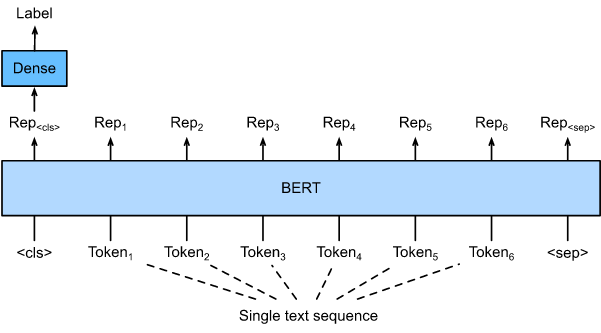

In [69]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
print(model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

For training, we will be using the Trainer API from Huggingface.

-  It will handle all details of training and validation
-  The [```Trainer```](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) object requires a [```TrainingArguments```](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) object that contains all the specifications of the training procedure



In [71]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="bert_mrpc", # where to save checkpoints and model predictions
                                  per_device_train_batch_size=8, # training batch size
                                  per_device_eval_batch_size=16, # validation/test batch sizie
                                  num_train_epochs=3, # number of epochs
                                  save_strategy='epoch', # checkpoint saving frequency
                                  evaluation_strategy="epoch",# how frequently to run validation, can be epoch or steps (in this case you need to specify eval_steps)
                                  metric_for_best_model="f1", # metric used to pick checkpoints
                                  greater_is_better=True, # whether the metric for checkpoint needs to be maximized or minimized
                                  learning_rate=3e-5, # learning rate or peak learning rate if scheduler is used
                                  optim="adamw_torch", # which optimizer to use
                                  lr_scheduler_type="linear", # which scheduler to use
                                  warmup_ratio=0.1, # % of steps for which to do warmup
                                  seed=33, # setting seed for reproducibility
                                  load_best_model_at_end=True) # after training, load the best checkpoint according to metric_for_best_model



- Other parameters to consider for your projects:
  - ```gradient_accumulation_steps``` and ```gradient_checkpointing``` if you have memory problems (batch doesn't fit in memory)
      - See [here](https://huggingface.co/docs/transformers/v4.18.0/en/performance#gradient-accumulation) for a full explanation of what they do 
  - ```report_to```  if you want to report your metrics, train loss to an external logger such as Weights & Biases (highly reccomended for your projects, see [wandb.ai](https://wandb.ai))
  - ```resume_from_checkpoint```: you can restart training from a checkpoint by passing the save path here




Let's define an evaluation function to be used during validation (and later for test)

In [72]:
import evaluate
import numpy as np
def compute_metrics_mrpc(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [73]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=mrpc_dataset["train"],
    eval_dataset=mrpc_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_mrpc
)

In [74]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.472064,0.811275,0.875203
2,0.505200,0.488288,0.845588,0.894118
3,0.256400,0.607004,0.860294,0.902896


TrainOutput(global_step=1377, training_loss=0.30870552035285326, metrics={'train_runtime': 215.0972, 'train_samples_per_second': 51.158, 'train_steps_per_second': 6.402, 'total_flos': 404712080911440.0, 'train_loss': 0.30870552035285326, 'epoch': 3.0})

### Computing performance on the test set

In [75]:
test_predictions = trainer.predict(mrpc_dataset["test"])
print(test_predictions.metrics)

{'test_loss': 0.6957690119743347, 'test_accuracy': 0.847536231884058, 'test_f1': 0.8896349139739823, 'test_runtime': 8.9659, 'test_samples_per_second': 192.395, 'test_steps_per_second': 12.046}


In [76]:
trainer.state.best_model_checkpoint # folder where best model is saved

'bert_mrpc/checkpoint-1377'

## Further reading/learning

- In this tutorial, we have covered parts of chapter 1-3 of the HuggingFace Course
    - Check the entire course [here](https://huggingface.co/learn/nlp-course/chapter1/1) to have a full understading of the library
    - Particularly, check how you can solve other tasks with HuggingFace transformers (NER, QA, Summarization) [here](https://huggingface.co/learn/nlp-course/chapter7/1?fw=pt)
- You should definitely learn to use a logger with your experiments
    - A logger tracks multiple metrics (loss, accuracy, F1) for every run and gives you the ability to compare different experiments
    - A good example of this is Weights & Biases (WandB): check the getting started [here](https://docs.wandb.ai/guide)